In [1]:
import rootutils

rootutils.setup_root("./", indicator=".project-root", pythonpath=True)

%load_ext autoreload
%autoreload 2

import torch
import torch_geometric
from topobenchmarkx.data.datasets import CustomDataset
import hydra
from hydra import initialize, compose
from topobenchmarkx.data.dataloader_fullbatch import FullBatchDataModule
from topobenchmarkx.io.load.loaders import (
    GraphLoader,
    SimplicialLoader,
    HypergraphLoader,
)
from omegaconf import DictConfig, OmegaConf
from topobenchmarkx.utils.config_resolvers import (
    get_default_transform,
    get_monitor_metric,
    get_monitor_mode,
    infer_in_channels,
)
from topobenchmarkx.data.dataloader_fullbatch import DefaultDataModule


OmegaConf.register_new_resolver("get_default_transform", get_default_transform)
OmegaConf.register_new_resolver("get_monitor_metric", get_monitor_metric)
OmegaConf.register_new_resolver("get_monitor_mode", get_monitor_mode)
OmegaConf.register_new_resolver("infer_in_channels", infer_in_channels)
OmegaConf.register_new_resolver(
    "parameter_multiplication", lambda x, y: int(int(x) * int(y))
)

initialize(config_path="../configs", job_name="job")
cfg = compose(config_name="train.yaml", return_hydra_config=True)

/tmp/ipykernel_543328/17376187.py:37: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../configs", job_name="job")


In [2]:
cfg.dataset.transforms.graph2simplicial_lifting.complex_dim = 3

In [3]:
# Instantiate and load dataset
dataset = hydra.utils.instantiate(cfg.dataset, _recursive_=False)
dataset = dataset.load()

Transform parameters are the same, using existing data_dir: /home/lev/projects/TopoBenchmarkX/datasets/graph/manual_dataset/manual/graph2simplicial_lifting_data_manipulations_simplicial_curvature/2646814658


In [4]:
if cfg.dataset.parameters.task_level == "node":
    datamodule = DefaultDataModule(dataset_train=dataset)

elif cfg.dataset.parameters.task_level == "graph":
    datamodule = DefaultDataModule(
        dataset_train=dataset[0],
        dataset_val=dataset[1],
        dataset_test=dataset[2],
        batch_size=cfg.dataset.parameters.batch_size,
    )
else:
    raise ValueError("Invalid task_level")

In [5]:
data = next(iter(datamodule.train_dataloader()))

In [6]:
# Plot the with seaborn
import matplotlib.pyplot as plt
import numpy as np

# # Plot the histogram 0_cell_curvature through away outliers
# plt.hist(data['0_cell_curvature'].numpy().flatten())
# plt.title('Histogram 0_cell_curvature')
# plt.show()



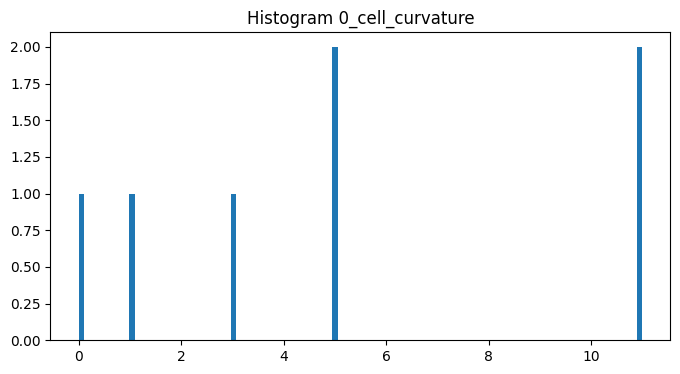

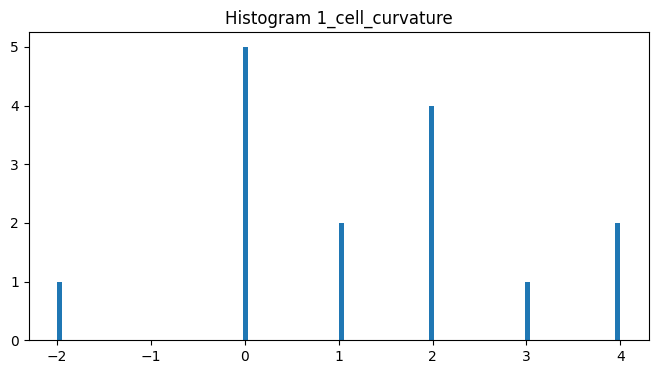

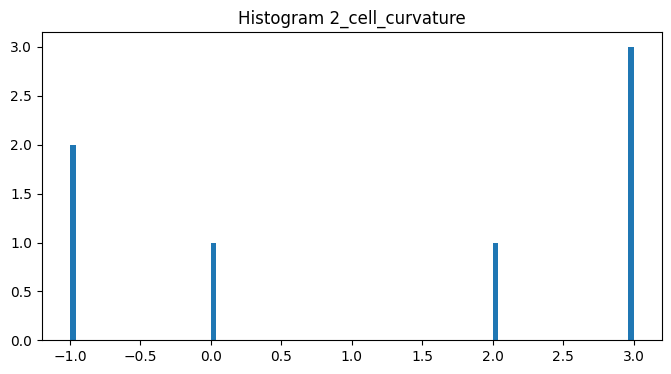

In [7]:
# Plot the histogram 0_cell_curvature through away outliers
zero_cell_curvature = data['0_cell_curvature'].numpy().flatten()
# calculate the 99 quantile and keep it
percentile = np.percentile(zero_cell_curvature, 5)
zero_cell_curvature = zero_cell_curvature[zero_cell_curvature > percentile]
# plot frequency of 0_cell_curvature
# Create a figure
fig = plt.figure(figsize=(8, 4))

plt.hist(zero_cell_curvature, bins=100)
plt.title('Histogram 0_cell_curvature')
plt.show()

# Plot the histogram 1_cell_curvature through away outliers
one_cell_curvature = data['1_cell_curvature'].numpy().flatten()
# calculate the 99 quantile and keep it
percentile = np.percentile(one_cell_curvature, 5)
one_cell_curvature = one_cell_curvature[one_cell_curvature > percentile]
# plot frequency of 1_cell_curvature
# Create a figure
fig = plt.figure(figsize=(8, 4))
plt.hist(one_cell_curvature, bins=100)
plt.title('Histogram 1_cell_curvature')
plt.show()

# Plot the histogram 2_cell_curvature through away outliers
two_cell_curvature = data['2_cell_curvature'].numpy().flatten()
# calculate the 99 quantile and keep it
percentile = np.percentile(two_cell_curvature, 5)
two_cell_curvature = two_cell_curvature[two_cell_curvature > percentile]
# plot frequency of 2_cell_curvature
# Create a figure
fig = plt.figure(figsize=(8, 4))
plt.hist(two_cell_curvature, bins=100)
plt.title('Histogram 2_cell_curvature')
plt.show()



### Correct plotting of manual graph

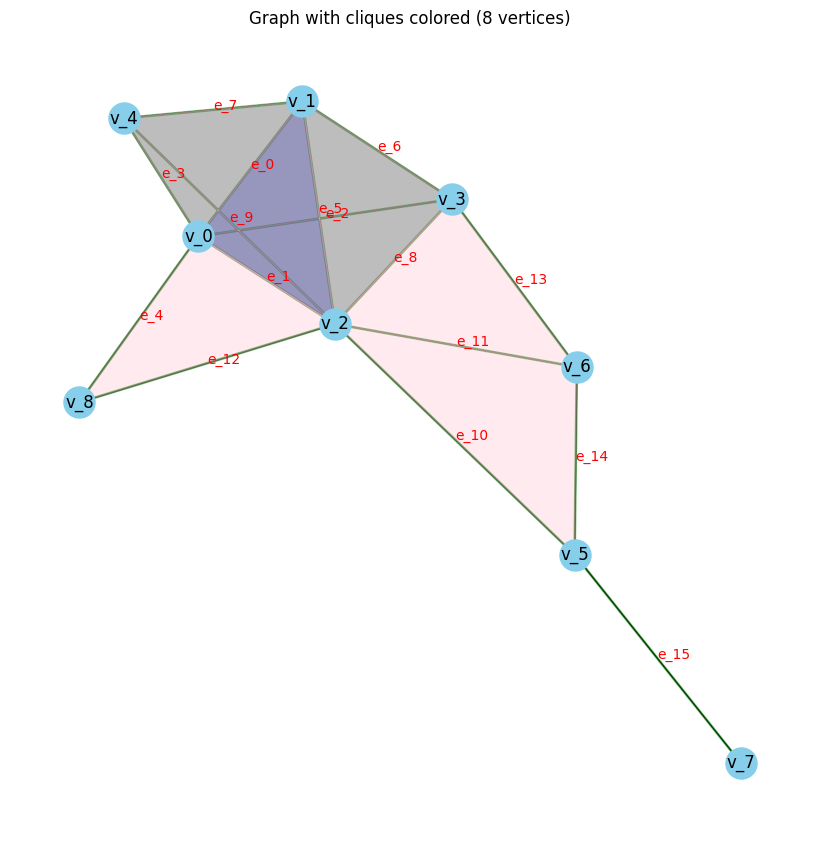

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Define the vertices (just 7 vertices)
vertices = [i for i in range(9)]

edges = []
for edge in data.incidence_1.to_dense().T:
    edges.append(torch.where(edge == 1)[0].numpy())
edges = np.array(edges)

# Define the tetrahedrons
tetrahedrons = [[0, 1, 2, 3], [0, 1, 2, 4]]

# Create a graph
G = nx.Graph()

# Add vertices
G.add_nodes_from(vertices)

# Add edges
G.add_edges_from(edges)
#G.to_undirected()



# Find cliques
#cliques = list(nx.find_cliques(G))
# Get all triangles in the graph
cliques = list(nx.enumerate_all_cliques(G))

# Filter triangles of order 3
cliques = [triangle for triangle in cliques if len(triangle) == 3]

# Plot the graph with edge indices using other layout
pos = nx.spring_layout(G, seed=5)

# Draw the graph with labels
nx.draw(G, pos, labels={i: f"v_{i}" for i in G.nodes()}, node_size=500, node_color="skyblue", font_size=12)

# Draw edges with different color and thickness
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color="g", width=2, alpha=0.5)

# Add edge indices
for i, (u, v) in enumerate(edges):
    x = (pos[u][0] + pos[v][0]) / 2
    y = (pos[u][1] + pos[v][1]) / 2
    plt.text(x, y, f"e_{i}", fontsize=10, color="r")

# Color the faces (cliques)
face_color_map = {0: "pink", 1: "gray", 2: "blue", 3: "blue", 4: "orange", 5: "purple", 6: "red", 7: "brown", 8: "black", 9: "gray"}    

for i, clique in enumerate(cliques):
    # Get the face color: 
    # Calculate to how many tetrahedrons cique belongs
    # Then assign the color to the face
    counter = 0
    for tetrahedron in tetrahedrons:
        from itertools import combinations
        for comb in combinations(tetrahedron,3):
            if set(clique) == set(comb):
                counter += 1
    
    polygon = [pos[v] for v in clique]
    poly = Polygon(polygon, closed=True, facecolor=face_color_map[counter], edgecolor='pink', alpha=0.3)
    plt.gca().add_patch(poly)

plt.title("Graph with cliques colored (8 vertices)")
plt.show()


In [ ]:
e_10 = {v_2,v_5} \in R^{2, d}
e_14 = {v_5,v_6}
e_11 = {v_2,v_6}

t_1  = {v_2,v_5,v_6}



1. {e_11, e_14} = MHA({e_11, e_14}, {e_11, e_14})
2. e_10 = MHA(e_10, {e_11, e_14})




Q=W_Q{e_11, e_14}
K=W_K{e_11, e_14}
V=W_V{e_11, e_14}

Att=  sigma (Q*K.T) / sqrt(d), \in (2,2)

Att V = [[alpha1 * e_11 + alpha2 * e_14], [alpha3 * e_11 + alpha4 * e_14]]


{[v_2, v_6], [v_5, v_6]} -- multiset


----------------------------------
e_10 = W[v_2, v_5]
e_14 = W[v_5, v_6]
e_11 = W[v_2, v_6]

t_1  = W[v_2, v_5, v_6]
----------------------------------
Precompute the edeg features from random walks
e_10 = e_rw

e_10 = [1/2 v_2 + 1/2 v_5, e_rw]


In [54]:
for i, degree in enumerate(data['0_cell_degrees'].numpy().flatten()):
    print(f'v_{i}', degree)

v_0 5.0
v_1 4.0
v_2 7.0
v_3 4.0
v_4 3.0
v_5 3.0
v_6 3.0
v_7 1.0
v_8 2.0


In [ ]:
for i, degree in enumerate(data['1_cell_degrees'].numpy().flatten()):
    print(f'e_{i}', degree)

In [67]:
for i, frc in enumerate(data['1_cell_curvature'].numpy().flatten()):
    print(f'frc_(e_{i})', frc)

frc_(e_0) 4.0
frc_(e_1) 4.0
frc_(e_2) 1.0
frc_(e_3) 2.0
frc_(e_4) 0.0
frc_(e_5) 2.0
frc_(e_6) 2.0
frc_(e_7) 3.0
frc_(e_8) 2.0
frc_(e_9) 0.0
frc_(e_10) -3.0
frc_(e_11) 0.0
frc_(e_12) -2.0
frc_(e_13) 0.0
frc_(e_14) 1.0
frc_(e_15) 0.0


In [69]:
data['0_cell_curvature'].numpy().flatten()[7]

0.0